In [15]:
import numpy as numpy
import pandas as pd

dfTMDB = pd.read_csv("TMDB/tmdb_5000_movies.csv")
dfTMDBcredits = pd.read_csv("TMDB/tmdb_5000_credits.csv")
dfTMDBcredits.drop("title", axis=1, inplace=True)
dfTMDBcredits.rename(columns={"movie_id": "id"},inplace=True)
dfTMDB = dfTMDB.merge(dfTMDBcredits, on="id")
dfRatings = pd.read_csv("TheMovies/ratings.csv")

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import joblib

dfTMDB["overview"] = dfTMDB["overview"].fillna("")
overviewTfdif = TfidfVectorizer(stop_words="english")
overviewTfdifMatrix = overviewTfdif.fit_transform(dfTMDB["overview"])
overviewCosSim = cosine_similarity(overviewTfdifMatrix)
joblib.dump(overviewCosSim, "overviewCosSim.joblib")

['overviewCosSim.joblib']

In [ ]:
from ast import literal_eval

features = ["cast", "keywords", "genres"]
for feature in features:
    dfTMDB[feature] = dfTMDB[feature].apply(literal_eval)

In [17]:
def getList(feature):
    if isinstance(feature, list):
        names = [i["name"] for i in feature]
        return names[:10]
for feature in features:
    dfTMDB[feature]=dfTMDB[feature].apply(getList)

In [19]:
def stringify(feature):
    nameList = [i.replace(" ", "").lower() for i in feature]
    nameString = " ".join(nameList)
    return nameString;

for feature in features:
    dfTMDB[feature]=dfTMDB[feature].apply(stringify)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

castCountV = CountVectorizer()
castMatrix = castCountV.fit_transform(dfTMDB["cast"])
castCosSim = cosine_similarity(castMatrix)

genreCountV = CountVectorizer()
genreMatrix = genreCountV.fit_transform(dfTMDB["genres"])
genreCosSim = cosine_similarity(genreMatrix)

keywordsCountV = CountVectorizer()
keywordsMatrix = castCountV.fit_transform(dfTMDB["keywords"])
keywordsCosSim = cosine_similarity(keywordsMatrix)

joblib.dump(castCosSim, "castCosSim.joblib")
joblib.dump(genreCosSim, "genreCosSim.joblib")
joblib.dump(keywordsCosSim, "keywordsCosSim.joblib")

['keywordsCosSim.joblib']

In [ ]:
def recommenderCosSim(movie_id, cosSimMatrix):
    movies = list(enumerate(cosSimMatrix[movie_id]))
    recommendations = sorted(movies, key=lambda x: x[1], reverse=True)[1:11]
    movieIndices = [i[0] for i in recommendations]
    return movieIndices

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict

reader = Reader()
tmdb_movie_ids = dfTMDB["id"].tolist()
filtered_ratings = dfRatings[dfRatings["movieId"].isin(tmdb_movie_ids)]

data = Dataset.load_from_df(filtered_ratings[["userId", "movieId", "rating"]], reader)
svd = SVD()
cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5)
trainset = data.build_full_trainset()
svd.fit(trainset)


def get_unseen_items(trainset, user_id):
    seen_items = set([j for (j, _) in trainset.ur[user_id]])
    all_items = set(trainset.all_items())
    unseen_items = all_items - seen_items
    return unseen_items


top_n = defaultdict(list)
user_id = 0
unseen_items = get_unseen_items(trainset, user_id)
predictions = [
    (
        item_id,
        svd.predict(trainset.to_raw_uid(user_id), trainset.to_raw_iid(item_id)).est,
    )
    for item_id in unseen_items
]
top_n = sorted(predictions, key=lambda x: x[1], reverse=True)[:10]

joblib.dump(trainset, "trainset.joblib")
joblib.dump(svd, "svd.joblib")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

dfTMDB = pd.read_csv("TMDB/tmdb_5000_movies.csv")
dfRatings = pd.read_csv("TheMovies/ratings.csv")

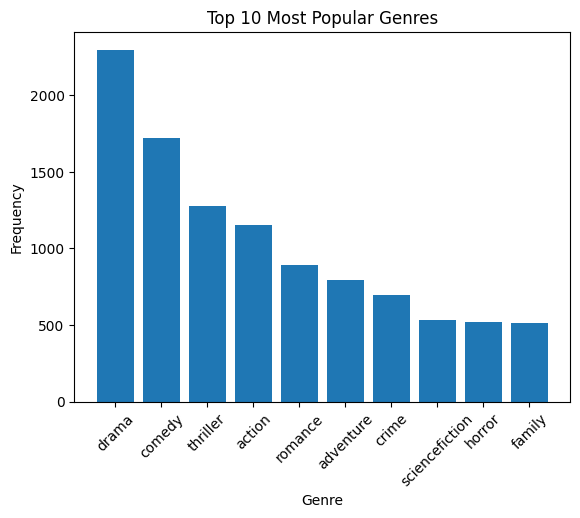

In [20]:
from collections import Counter
genre_counts = Counter([genre for sublist in dfTMDB['genres'] for genre in sublist.split()])
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True)[:10])
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.title('Top 10 Most Popular Genres')
plt.xticks(rotation=45)
plt.show()

In [22]:
import joblib
trainset = joblib.load('trainset.joblib')

<BarContainer object of 10 artists>

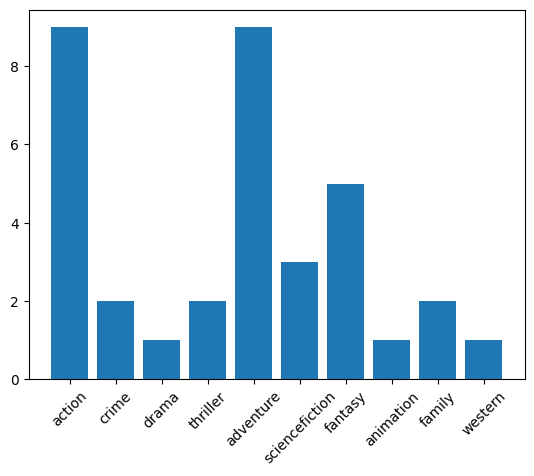

In [ ]:
def getUserRatedMovies(trainset, rawUserID):
    userInnerId = trainset.to_inner_uid(rawUserID)
    ratedMovies = [
        (trainset.to_raw_uid(itemId), rating)
        for (itemId, rating) in trainset.ur[userInnerId]
    ]
    return ratedMovies


ratedMovies = getUserRatedMovies(trainset, 2)
genreDict = {}
for index, rating in ratedMovies:
    genres = dfTMDB.iloc[index]["genres"].split()
    for genre in genres:
        if genre in genreDict:
            genreDict[genre] += 1
        else:
            genreDict[genre] = 1
genreDict

plt.xticks(rotation=45)
plt.bar([i for i in genreDict], [genreDict[i] for i in genreDict])

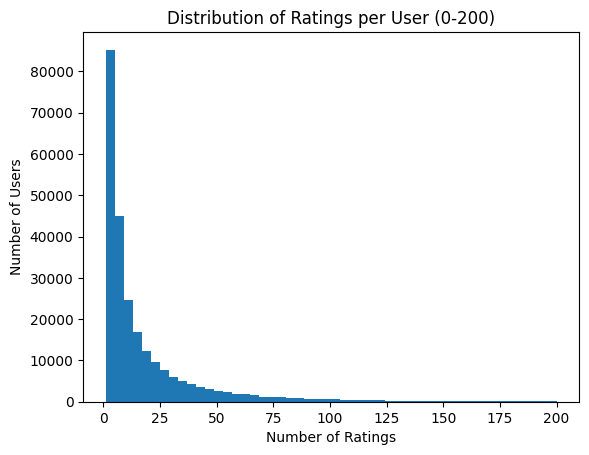

In [47]:
import matplotlib.pyplot as plt

user_ratings_count = filtered_ratings.groupby("userId")["rating"].count()
filtered_user_ratings_count = user_ratings_count[
    (user_ratings_count >= 0) & (user_ratings_count <= 200)
]


plt.hist(filtered_user_ratings_count, bins=50)
plt.title("Distribution of Ratings per User (0-200)")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.show()

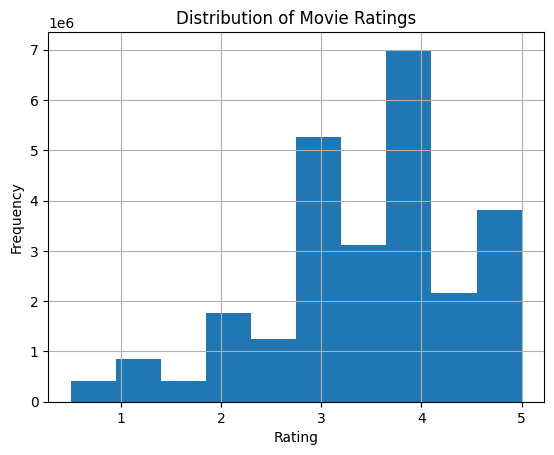

In [ ]:
import matplotlib.pyplot as plt
dfRatings['rating'].hist(bins=10)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Movie Ratings')
plt.show()